<a href="https://colab.research.google.com/github/kaledai069/Crossword-Generator/blob/master/Grid_answer_clue_pair_generator_Approach_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/kaledai069/Crossword-Solver-A-Neural-Transformer-based-Approach
%cd Crossword-Solver-A-Neural-Transformer-based-Approach/
!bash inference_setup.sh

Cloning into 'Crossword-Solver-A-Neural-Transformer-based-Approach'...
remote: Enumerating objects: 3092, done.
remote: Counting objects: 100% (1792/1792), done.
remote: Compressing objects: 100% (1424/1424), done.
remote: Total 3092 (delta 469), reused 1679 (delta 364), pack-reused 1300
Receiving objects: 100% (3092/3092), 15.90 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (663/663), done.
/content/Crossword-Solver-A-Neural-Transformer-based-Approach
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [72]:
import json
import os
import pandas as pd
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from tqdm import tqdm

In [73]:
CA_DATASET = "/content/gdrive/MyDrive/Clue-Answer Dataset/Clue-Answer-Dataset_Version_2.csv"

clue_answer_df = pd.read_csv(CA_DATASET)
clue_answer_df['Unsegmented Answer'] = clue_answer_df['Segmented Answer'].apply(lambda x: x.replace(' ', '') if not isinstance(x, float) else x)

all_clues = clue_answer_df['Clue'].tolist()
all_answers = clue_answer_df['Unsegmented Answer'].tolist()
clue_answer_df.head()

,Unnamed: 0,Clue,Answer,Segmented Answer,answer_length,Unsegmented Answer
0,0,cpa for example crossword clue,taxpro,tax pro,6.0,taxpro
1,1,cordial crossword clue,warm,warm,4.0,warm
2,2,joe without jolt crossword clue,decaf,decaf,5.0,decaf
3,3,bouillabaisse bit crossword clue,mussel,mussel,6.0,mussel
4,4,pre-gps travel aid crossword clue,aaamap,aaa map,6.0,aaamap


In [74]:
answer_list = clue_answer_df[clue_answer_df['Unsegmented Answer'].apply(lambda x: len(str(x)) == 3 or len(str(x)) == 4 or len(str(x)) == 5 )]['Unsegmented Answer'].unique().tolist()

In [75]:
filtered_answer = []

for answer in answer_list:
    if not isinstance(answer, float):
        filtered_answer.append(answer)

with open("/content/answer_list.txt", 'w') as f:
    f.write("\n".join(filtered_answer))

In [76]:
def get_me_a_random_clue(answer_length):
    random_index = random.randint(0, len(all_clues))
    while 'across' in all_clues[random_index] or 'down' in all_clues[random_index]:
        random_index = random.randint(0, len(all_clues))
    return all_clues[random_index]

def find_grid_position(grid_nums, clue_num, n_rows):
    reshaped_grid = [grid_nums[i:i + n_rows] for i in range(0, len(grid_nums), n_rows)]

    for i in range(len(reshaped_grid)):
        for j in range(len(reshaped_grid[0])):
            if reshaped_grid[i][j] == clue_num:
                return (i, j)

def find_answer_length(main_grid, position, grid_size, across = True):
    rows, cols = grid_size
    i, j = position
    count = 0
    if across:
        for idx in range(j, cols):
            if main_grid[i][idx] == '.':
                return count
            else:
                count += 1
    else:
        for idx in range(i, rows):
            if main_grid[idx][j] == '.':
                return count
            else:
                count += 1
    return count

def json_CA_json_converter(json_file_path, is_path):
    if is_path:
        with open(json_file_path, "r") as file:
            data = json.load(file)
    else:
        data = json_file_path

    json_conversion_dict = {}

    rows = data["size"]["rows"]
    cols = data["size"]["cols"]

    grid_list = data['grid']

    main_grid = [grid_list[i:i + rows] for i in range(0, len(grid_list), rows)]


    json_conversion_dict["metadata"] = {"rows": rows, "cols": cols}

    across_grid_nums = data['across_nums']
    down_grid_nums = data['down_nums']

    across_clue_answer = {}
    down_clue_answer = {}

    grid_info = data["grid"]
    grid_num = data["gridnums"]
    reshaped_grid = [grid_num[i:i + rows] for i in range(0, len(grid_num), rows)]

    for clue_num in across_grid_nums:
      position = find_grid_position(grid_num, clue_num, rows)
      answer_count = find_answer_length(main_grid, position, (rows, cols))
      random_clue = get_me_a_random_clue(answer_count)
      across_clue_answer[str(clue_num)] = [random_clue, "".join(['A' for _ in range(answer_count)])]

    for clue_num in down_grid_nums:
      position = find_grid_position(grid_num, clue_num, rows)
      answer_count = find_answer_length(main_grid, position, (rows, cols), False)
      random_clue = get_me_a_random_clue(answer_count)
      down_clue_answer[str(clue_num)] = [random_clue, "".join(['A' for _ in range(answer_count)])]

    json_conversion_dict["clues"] = {
          "across": across_clue_answer,
          "down": down_clue_answer,
      }

    grid_info_list = []
    for i in range(rows):
        row_list = []
        for j in range(cols):
            if grid_info[i * rows + j] == ".":
                row_list.append("BLACK")
            else:
                if grid_num[i * rows + j] == 0:
                    row_list.append(["", grid_info[i * rows + j]])
                else:
                    row_list.append(
                        [str(grid_num[i * rows + j]), grid_info[i * rows + j]]
                    )
        grid_info_list.append(row_list)

    json_conversion_dict["grid"] = grid_info_list

    return json_conversion_dict

## Inference with the crossword solver

#### Important imports for solver

In [77]:
import datetime
import time
import matplotlib.pyplot as plt
import cv2
import pprint
import shutil
import os

from copy import deepcopy
from pprint import pprint
from matplotlib.gridspec import GridSpec

from solver.Crossword import Crossword
from solver.BPSolver import BPSolver
from utils import puz_to_json, fetch_nyt_crossword
from draw_grid import get_grid


In [78]:
model_path = "/content/gdrive/MyDrive/First Pass Model/distilbert_EPOCHs_7_COMPLETE.bin"
ans_path = "/content/gdrive/MyDrive/First Pass Model/new_answer_list.tsv"
dense_embd_path = "/content/gdrive/MyDrive/First Pass Model/distilbert_embeddings_v2_0.pkl"

reranker_path = "/content/gdrive/MyDrive/Second Pass Model/t5_word_segmented_pair_2_epochs"
reranker_model_type = 't5-small'

In [192]:
def solve(crossword, m_path, a_path, d_path, r_path, reranker_m_type, max_candidate = 50000, score_threshold = 0.5):
    solver = BPSolver(
                      crossword,
                      model_path = m_path,
                      ans_tsv_path = a_path,
                      dense_embd_path = d_path,
                      reranker_path = r_path,
                      reranker_model_type = reranker_m_type,
                      max_candidates = max_candidate,
                      score_improvement_threshold = score_threshold
                      )

    solution = solver.solve(num_iters = 100, iterative_improvement_steps = 0)
    return solution

#### Generate and Visualize crossword-grid

In [165]:
from PIL import Image, ImageDraw, ImageFont

def create_crossword_filled_img(grid, grid_nums, grid_fill = None, invalid_cells = [], ):

    cell_size = 30
    black_square_color = 'black'
    text_color = 'black'

    height = len(grid) * cell_size + 1
    width = len(grid[0]) * cell_size + 1

    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)

    font = ImageFont.load_default()

    # Adjust font size
    font_size = 8  # Set your desired font size
    font_1 = ImageFont.truetype("/content/Roboto-Regular.ttf", font_size)
    font_2 = ImageFont.truetype("/content/Roboto-Regular.ttf", 12)

    for row in range(len(grid)):
        for col in range(len(grid[row])):
            x = col * cell_size
            y = row * cell_size
            rect = [(x, y), (x + cell_size, y + cell_size)]

            if (row, col) in invalid_cells:
                draw.rectangle(rect, fill = (255, 102, 102))

            if grid[row][col] == ".":
                draw.rectangle(rect, fill = black_square_color)

            else:
                draw.rectangle(rect, outline = "black")
                if grid_fill is not None:
                    draw.text((x + cell_size // 2 , y + cell_size // 2), str(grid_fill[row][col]), fill=text_color, anchor="mm", font=font_2)
                if grid_nums[row][col] != 0:
                      draw.text((x + cell_size // 2 - 7, y + cell_size // 2 - 8), str(grid_nums[row][col]), fill=text_color, anchor="mm", font=font_1)

    img_array = np.array(img)
    return img_array


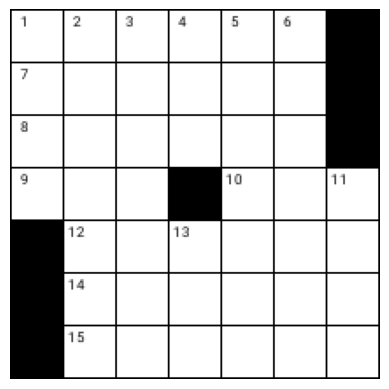

In [214]:
from grid_generator import generate_grid

grid_img_array, json_data = generate_grid(grid_size = 7, return_grid = True)
plt.imshow(grid_img_array)
plt.axis('off')
plt.show()

In [215]:
puzzle = json_CA_json_converter(json_data, False)

crossword = Crossword(puzzle)
start_t = time.time()
output = solve(crossword, model_path, ans_path, dense_embd_path, reranker_path, "t5-small", 60000, 0.5)
end_t = time.time()

print("Total time taken: ", end_t - start_t)


Beginning Belief Propagation iteration steps


100%|█████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.02it/s]


Belief Propagation iteration complete

Before Iterative Improvement with t5-small: Letters Correct: 0.0% | Words Correct: 0.0%
Total time taken:  57.227821588516235


In [216]:
first_pass_grid = output['first pass model']['grid']
# second_pass_grid = output['second pass model']['all grids'][0]

pprint(first_pass_grid)

clue_answer_pair = {}
generated_answer_list = []

test_grid = first_pass_grid
for key, var in crossword.variables.items():
  cells_val = var['cells']
  word = ''
  for cell in cells_val:
    word += test_grid[cell[0]][cell[1]]
  generated_answer_list.append((key, word))
  clue_answer_pair[key] = {
      'clue': var['clue'],
      'answer': word
  }

print("Total answers: ", len(generated_answer_list))

found_answer = []
not_found_answer = []

not_found_red_cells = set()

for key, answer in generated_answer_list:
    if answer.lower() in all_answers:
        clue = random.choice(clue_answer_df[clue_answer_df['Unsegmented Answer'] == answer.lower()]['Clue'].tolist())
        found_answer.append([key, clue, answer, crossword.variables[key]['cells']])
    else:
        not_found_answer.append([key, answer, crossword.variables[key]['cells']])
        for cell in crossword.variables[key]['cells']:
            not_found_red_cells.add(cell)

print("Actual answers found: ", len(found_answer))
found_answer

[['Y', 'A', 'M', 'A', 'H', 'A', ''],
 ['A', 'V', 'O', 'W', 'E', 'R', ''],
 ['T', 'A', 'R', 'T', 'A', 'R', ''],
 ['T', 'O', 'B', '', 'F', 'U', 'N'],
 ['', 'D', 'O', 'U', 'A', 'N', 'E'],
 ['', 'S', 'E', 'V', 'I', 'E', 'R'],
 ['', 'S', 'T', 'A', 'N', 'N', 'O']]
Total answers:  16
Actual answers found:  10


[['1A',
  'japanese name on many instruments',
  'YAMAHA',
  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]],
 ['7A',
  'acknowledging one',
  'AVOWER',
  [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]],
 ['8A',
  'the type of deposit made by sailors (wordplay)',
  'TARTAR',
  [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]],
 ['9A', 'book of the apocrypha abbreviation', 'TOB', [(3, 0), (3, 1), (3, 2)]],
 ['10A',
  "however enjoyable, that's enough to have made gus mouldy",
  'FUN',
  [(3, 4), (3, 5), (3, 6)]],
 ['11D',
  'successor of claudius crossword clue',
  'NERO',
  [(3, 6), (4, 6), (5, 6), (6, 6)]],
 ['12A',
  'where french will interrupt visitor from copenhagen (wordplay)',
  'DOUANE',
  [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]],
 ['13D', 'the cavaliers of the a.c.', 'UVA', [(4, 3), (5, 3), (6, 3)]],
 ['14A',
  "tennessee's first governor, john ___",
  'SEVIER',
  [(5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)]],
 ['15A',
  'tin prefix.',
  'STANNO',
  [(6, 1), (

1A - Clue : japanese name on many instruments | Answer : YAMAHA
7A - Clue : acknowledging one | Answer : AVOWER
8A - Clue : the type of deposit made by sailors (wordplay) | Answer : TARTAR
9A - Clue : book of the apocrypha abbreviation | Answer : TOB
10A - Clue : however enjoyable, that's enough to have made gus mouldy | Answer : FUN
11D - Clue : successor of claudius crossword clue | Answer : NERO
12A - Clue : where french will interrupt visitor from copenhagen (wordplay) | Answer : DOUANE
13D - Clue : the cavaliers of the a.c. | Answer : UVA
14A - Clue : tennessee's first governor, john ___ | Answer : SEVIER
15A - Clue : tin prefix. | Answer : STANNO


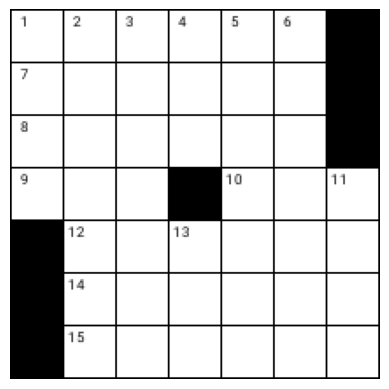

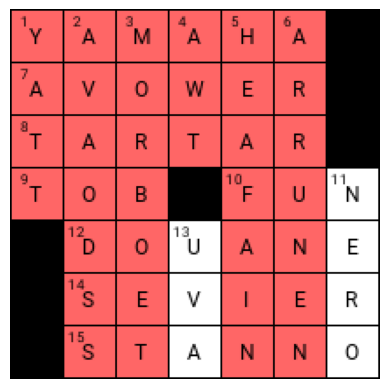

In [217]:
rows = cols = 7
grid_nums = json_data['gridnums']
reshaped_gridnum = [grid_nums[i:i + rows] for i in range(0, len(grid_nums), rows)]
grid = json_data['grid']
reshaped_grid = [grid[i:i + rows] for i in range(0, len(grid), rows)]

fill_grid = first_pass_grid.copy()
clue_answer_pair = {}
for filled_pair in found_answer:
    relevant_cells = filled_pair[-1]
    gold_answer = filled_pair[2]
    key = filled_pair[0]
    clue = filled_pair[1]
    clue_answer_pair[key] = [clue, answer]
    print(f"{filled_pair[0]} - Clue : {filled_pair[1]} | Answer : {gold_answer}")
    for i, cell in enumerate(relevant_cells):
        fill_grid[cell[0]][cell[1]] = gold_answer[i]

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

empty_grid = create_crossword_filled_img(reshaped_grid, reshaped_gridnum, None, [])
filled_grid = create_crossword_filled_img(reshaped_grid, reshaped_gridnum, fill_grid, list(not_found_red_cells),)

plt.imshow(empty_grid)
plt.axis('off')
plt.savefig("/content/empty_grid_7x7_1.png", dpi = 240, bbox_inches = 'tight')
plt.show()

plt.imshow(filled_grid)
plt.axis('off')
plt.savefig("/content/filled_grid_7x7_1.png", dpi = 240, bbox_inches = 'tight')
plt.show()


# axes[0].imshow(empty_grid)
# axes[0].set_title("Empty Grid")
# axes[0].axis('off')

# axes[1].imshow(filled_grid)
# axes[1].set_title("Filled Grid")
# axes[1].axis('off')



#### Other unnecessary stuffs

In [ ]:
to_find_cells = crossword.variables[not_found_answer[0][0]]['cells']

for key, answer in found_answer:
    all_cells = crossword.variables[key]['cells']
    for cell in all_cells:
        if cell in to_find_cells:
            print(to_find_cells[to_find_cells.index(cell)])
            print(key, answer)

(0, 3)
1D REO
(0, 4)
2D BATTEN
(0, 5)
3D INTENT
(0, 6)
4D NSECS


100%|███████████████████████████████████████████| 27/27 [00:13<00:00,  2.01it/s]


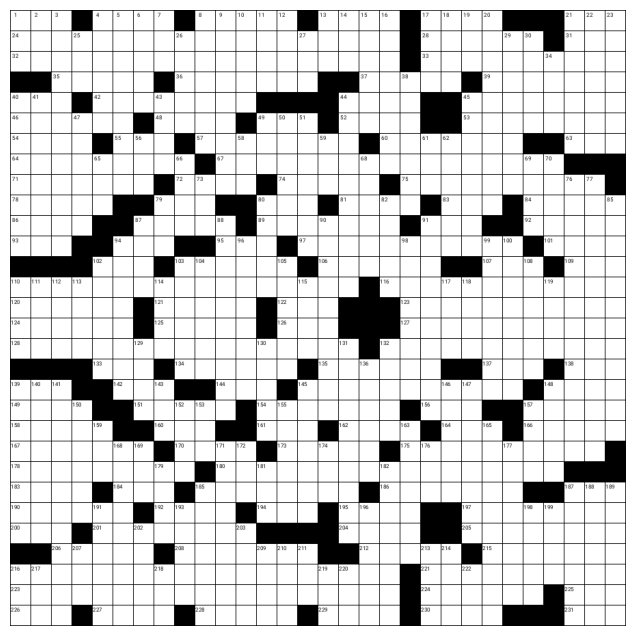

In [ ]:


time_info_list = []
for grid_size in tqdm(range(4, 31), ncols = 80):
    start_t = time.time()
    grid_img_array = generate_grid(grid_size = grid_size, return_grid = True)
    end_t = time.time()

    time_info_list.append((grid_size, (end_t - start_t) * 1000))

plt.figure(figsize = (8, 8))
plt.imshow(grid_img_array)
plt.axis('off')
plt.show()

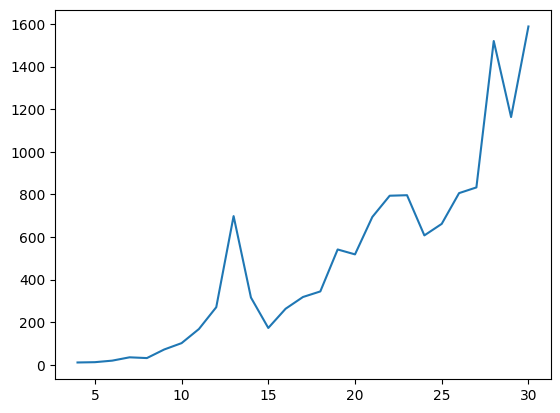

In [ ]:
time_info_list = np.array(time_info_list)
plt.plot(time_info_list[:, 0], time_info_list[:, 1])
# plt.xticks(range(len(time_info_list)))
plt.show()